# Primary and subsequent fraction

This notebook creates the extended Primary and subsequent fraction figure from the SI material

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.ticker as ticker

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
       'Netherlands']
traces, models, dls = [], [], []
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None:
        print(" not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Italy
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for Belgium
Use 4000 sample runs for France
Use 4000 sample runs for Portugal
Use 4000 sample runs for Netherlands


In [4]:
infections_no = []
infections_primary = []
infections_secondary = []
for i, country in tqdm(enumerate(countries)):
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = traces[i].posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_secondary.append(y2)

0it [00:00, ?it/s]

In [9]:

data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))

country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_secondary[i])/(infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100
    t_numpy = t_numpy[(t_numpy < 100).all(axis=1), :]
    t_numpy = t_numpy[(t_numpy > -100).all(axis=1), :]
    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]


# As the conctac matrix is symmetric for the subsequant infections we can just plot the violin plots
data_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = infections_secondary[i].sum(axis=-1)/(infections_no[i] + infections_primary[i] + infections_secondary[i]).sum(axis=-1) * 100

    # Create dataframe for plotting
    temp = pd.DataFrame(t_numpy, columns=["percentage_secondary"])
    temp["country"] = country
    data_subsequent = pd.concat([data_subsequent, temp])
    means.append(np.median(temp["percentage_secondary"]))

country_order_subsequent = np.argsort(means)[::-1]


primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country"])
    temp_m = temp[temp["gender"]=="male"].drop(columns=["gender"])
    temp_f = temp[temp["gender"]=="female"].drop(columns=["gender"])
    primary_and_subsequent_frac.append(np.array([temp_m.to_numpy()[:,0],temp_f.to_numpy()[:,0]]))

In [6]:
data_primary

,percentage_primary,gender,country
0,15.502961,male,England
1,14.288389,male,England
2,17.242900,male,England
3,18.023818,male,England
4,16.998208,male,England
...,...,...,...
63995,-1.330059,female,Netherlands
63996,-0.642101,female,Netherlands
63997,-0.612112,female,Netherlands
63998,-0.895895,female,Netherlands


In [7]:
data_primary_and_subsequent

,percentage_primary_and_subsequent,gender,country
0,51.992256,male,England
1,50.352275,male,England
2,54.072919,male,England
3,56.977678,male,England
4,54.444130,male,England
...,...,...,...
60029,-45.768450,female,Netherlands
60030,-35.612033,female,Netherlands
60031,-31.496630,female,Netherlands
60032,-48.709831,female,Netherlands


In [8]:
import matplotlib.ticker as mtick
from covid19_soccer.plot.rcParams import *
from covid19_soccer.plot.utils import get_flag
from covid19_soccer.plot.other import legend
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from covid19_soccer.plot.other import plot_flags
from covid19_soccer.plot.other import soccer_related_cases_overview, vviolins

fig, ax = plt.subplots(1,1,figsize=(2.25,2))







begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)

# Configs
color_male = rcParams.color_male
color_female = rcParams.color_female
vertical = False
country_order = np.arange(len(countries))
percentage = data_primary_and_subsequent
overall_effect_trace = None
ypos_flags = -90
plot_flags=True

to_y = "percentage_primary_and_subsequent"
to_x = "country"
if vertical:
    to_x = "percentage_primary_and_subsequent"
    to_y = "country"

g = sns.violinplot(
    data=percentage,
    y=to_y,
    x=to_x,
    hue="gender",
    scale="count",
    inner=None,
    orient="h" if vertical else "v",
    ax=ax,
    split=True,
    # palette={"male": color_male, "female": color_female},
    linewidth=1,
    saturation=1,
    width=0.75,
    order=np.array(countries)[country_order],
)

c = 0
for i, col in enumerate(ax.collections):
    # Update colors if they are set to force overwriting
    if colors is not None:
        if len(colors) != 2:
            color_male = rcParams.color_male
            color_female = rcParams.color_female

    if i % 2 == 0:
        ax.collections[i].set_facecolor(color_male)
        ax.collections[i].set_edgecolor(color_male)  # Set outline colors
    else:
        ax.collections[i].set_facecolor(color_female)
        ax.collections[i].set_edgecolor(color_female)  # Set outline colors

""" Draw error whiskers
"""
draw_inner_errors = True
if draw_inner_errors:
    print(f"Country\t2.5\t50.0\t97.5\t>0")
    for i, country in enumerate(np.array(countries)[country_order]):

        if country == "overall":
            t = np.array(
                percentage[percentage["country"] == country]["percentage_primary_and_subsequent"]
            ).reshape((2, -1))
            print((t[0, :] > 0).sum() / t[0, :].shape[0])
            print((t[1, :] > 0).sum() / t[1, :].shape[0])

        temp = (
            np.array(
                percentage[percentage["country"] == country]["percentage_primary_and_subsequent"]
            )
            .reshape((2, -1))
            .mean(axis=0)
        )

        l, mean, u = np.percentile(temp, q=(2.5, 50, 97.5))
        print(country, l, mean, u, (temp > 0).sum() / temp.shape[0], sep="\t")

        if vertical:
            ax.scatter(
                x=mean,
                y=i,
                marker="o",
                s=10,
                zorder=10,
                c="white",
                edgecolor="#060434",
            )
            lines = ax.hlines(
                y=i, xmin=l, xmax=u, lw=1.5, zorder=9, color="#060434",
            )
            lines.set_capstyle("round")
        else:
            ax.scatter(
                x=i,
                y=mean,
                marker="o",
                s=10,
                zorder=10,
                c="white",
                edgecolor="#060434",
            )
            lines = ax.vlines(
                x=i, ymin=l, ymax=u, lw=1.5, zorder=9, color="#060434",
            )
            lines.set_capstyle("round")

""" Markup
"""

if vertical:
    ax.set_xlabel("Fraction of primary and subsequent\ncases related to the Euro 2020")
    ax.set_ylabel("")
    ax.set_yticklabels(countries)
else:
    ax.set_ylabel("Fraction of primary and subsequent\ncases related to the Euro 2020")
    ax.set_xlabel("")
    ax.set_xticklabels(countries)

# plot flags if desired
if plot_flags:
    iso2 = []
    if not overall_effect_trace is None:
        dls_orderd = np.array(dls)[country_order[1:]]
        img = plt.imread(get_flag("football"))
        im = OffsetImage(img, zoom=0.03)
        iso2.append("Avg.")

        if vertical:
            pos = (ypos_flags, 0)
            xybox = (-10, 0)
        else:
            pos = (0, ypos_flags)
            xybox = (0, -10)

        ab = AnnotationBbox(
            im,
            pos,
            xybox=xybox,
            frameon=False,
            xycoords="data",
            boxcoords="offset points",
            pad=0,
        )
        ax.add_artist(ab)
        offset = 1
    else:
        dls_orderd = np.array(dls)[country_order]
        offset = 0
    for i, dl in enumerate(dls_orderd):
        iso2.append(dl.countries_iso2[0].replace("GB-", ""))
        img = plt.imread(get_flag(dl.countries_iso2[0].lower()))
        im = OffsetImage(img, zoom=0.03)
        im.image.axes = ax

        if vertical:
            pos = (ypos_flags, i + offset)
            xybox = (-10, 0)
        else:
            pos = (i + offset, ypos_flags)
            xybox = (0, -10)

        ab = AnnotationBbox(
            im,
            pos,
            xybox=xybox,
            frameon=False,
            xycoords="data",
            boxcoords="offset points",
            pad=0,
        )
        ax.add_artist(ab)

    if vertical:
        ax.set_yticklabels(iso2)
        ax.tick_params(axis="y", which="major", pad=21, length=0)
    else:
        ax.set_xticklabels(iso2)
        ax.tick_params(axis="x", which="major", pad=21, length=0)

# Remove legend
ax.legend([], [], frameon=False)

# Set y tick formats
fmt = "%.0f%%"  # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
if vertical:
    ax.xaxis.set_major_formatter(xticks)
else:
    ax.yaxis.set_major_formatter(xticks)

if vertical:
    ax.axvline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(True)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
else:
    ax.axhline(0, color="tab:gray", ls="--", zorder=-10)
    # Remove spines
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    
ax.set_ylim(-90,100)
legend(ax,
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc=1
)


Country	2.5	50.0	97.5	>0
England	36.89662294068664	47.767924298388124	62.609412797344326	1.0
Czechia	28.691795880140525	57.7159252892546	72.62545237196952	0.998
Scotland	31.692713231377578	40.789229667100514	49.252180149403436	1.0
Spain	-16.78103119142982	26.929412631042116	69.08200648285396	0.893845143946735
Italy	-81.39862104265556	24.645648661620193	78.87358880152676	0.6904729077623053
Slovakia	-59.48172966731085	18.22522520510679	60.13055094719727	0.7283005572993402
Germany	-32.151619630931044	23.691704864822285	48.63319613663022	0.8745640219952867
Austria	-52.48081285416396	25.632419880903214	65.29319093956387	0.796284594970302
Belgium	-56.48175825483917	9.988326942668305	51.85512945234357	0.6539623591615786
France	-8.588694639409454	23.644743716806474	47.01022373759889	0.9380357142857143
Portugal	-53.79375335410211	-3.973122926927179	26.966842467237395	0.40361067503924647
Netherlands	-92.13740798245426	-48.63014140438135	-1.0071808076169775	0.022787087317186927


FileNotFoundError: [Errno 2] No such file or directory: './figures/iso2/gb-eng.png'

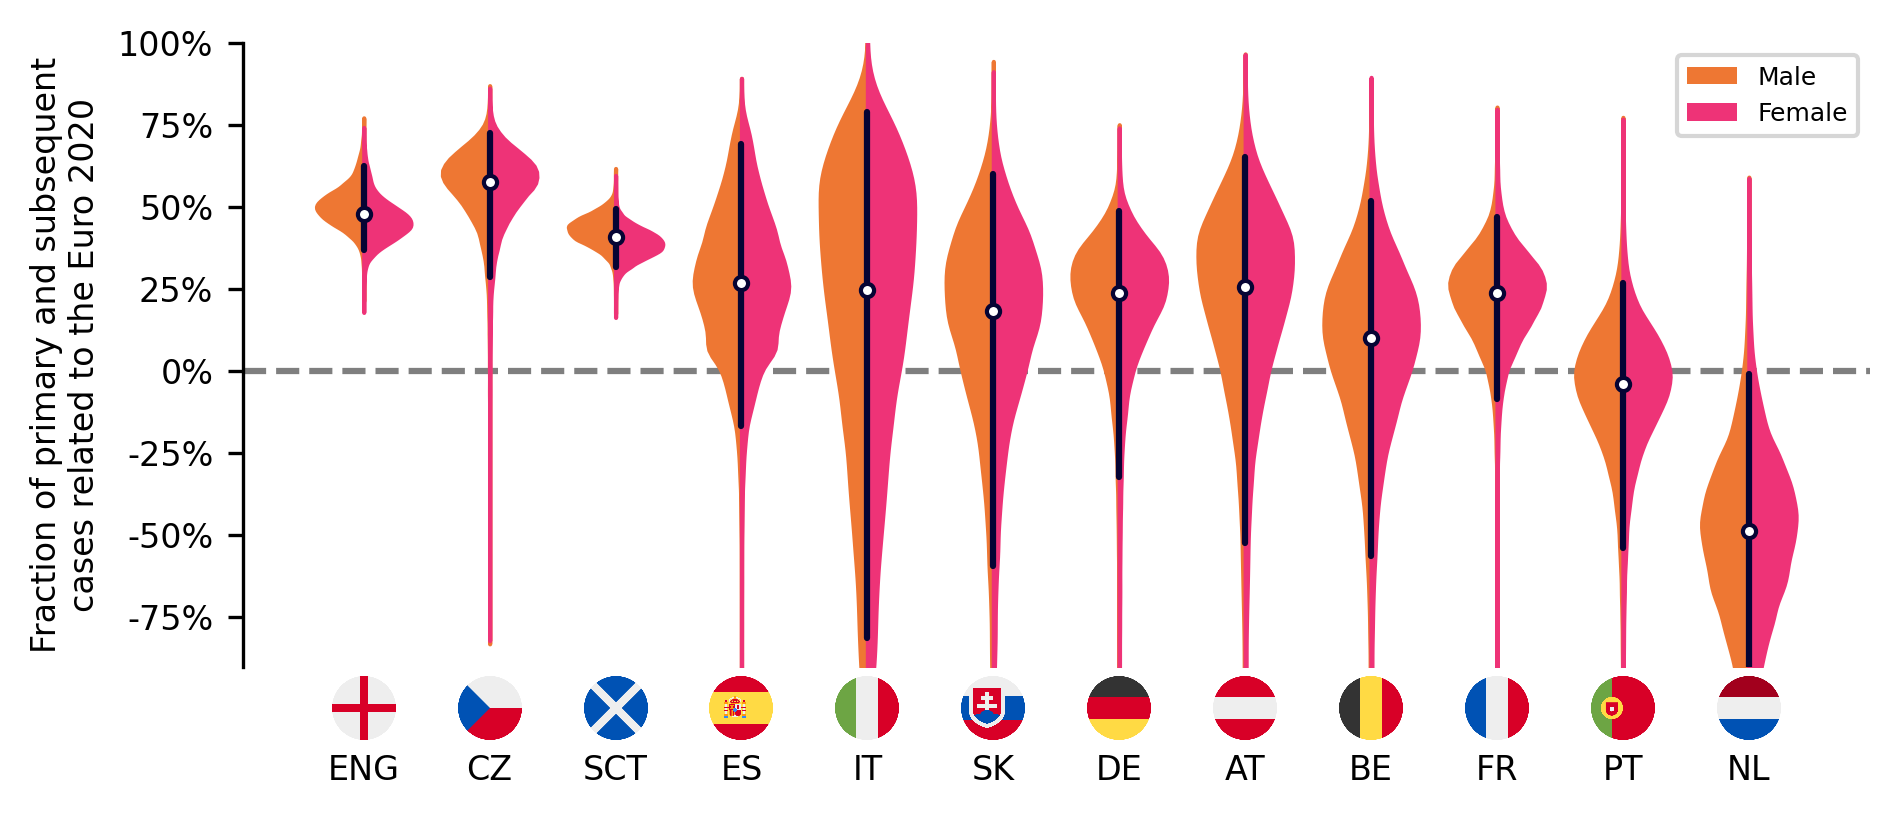

In [56]:
plt.show()
fig_path = "../figures/SI"
fig.savefig(f"{fig_path}/primary_and_subsequent.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_and_subsequent.png", **save_kwargs)
plt.close(fig=fig)

In [15]:
from covid19_soccer.plot.other import plot_flags
from covid19_soccer.plot.other import soccer_related_cases_overview, vviolins


def whisker_plot(ax,y,x_median,x_lower_95,x_upper_95,x_lower_68,x_upper_68):
    lines = ax.hlines(
        y=y,
        xmin=x_lower_95,
        xmax=x_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.hlines(
        y=y,
        xmin=x_lower_68,
        xmax=x_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        y=y,
        x=x_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.axvline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(False)
    ax.set_yticklabels([])
    ax.tick_params(axis="y",left=False)

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1110: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1114: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


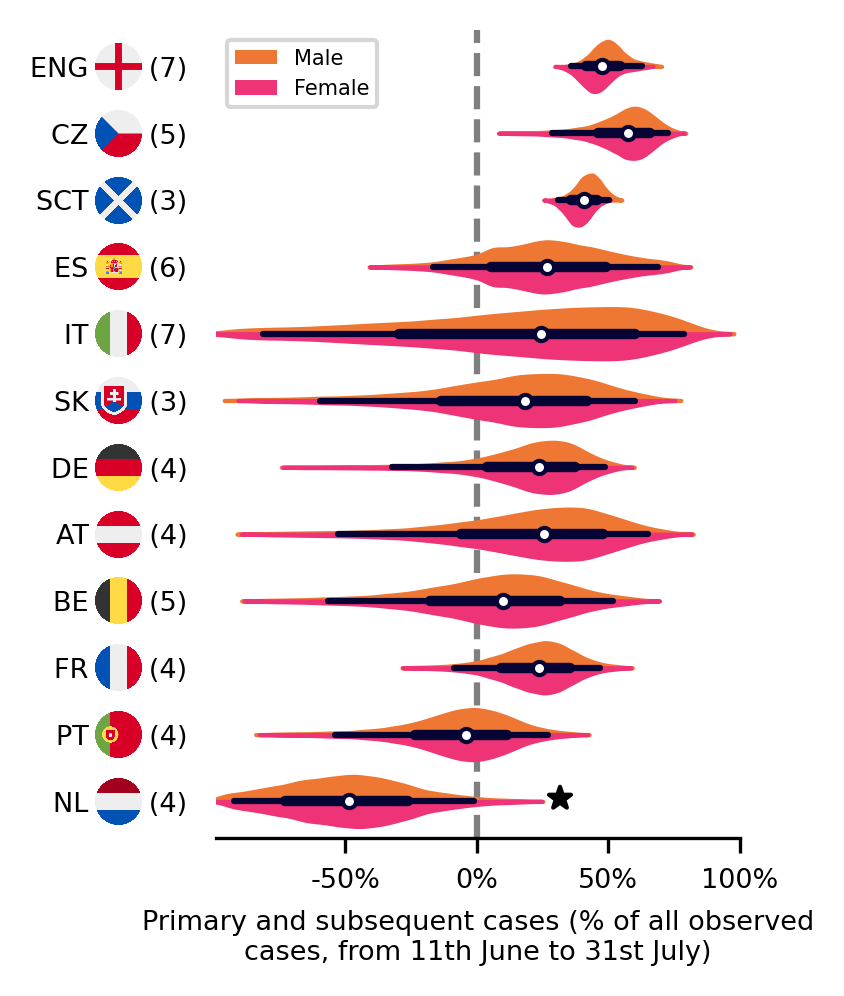

In [69]:
fig, ax = plt.subplots(1,1,figsize=(2.25,3.5))

vviolins(
    ax,
    countries,
    primary_and_subsequent_frac
)


ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_and_subsequent_frac]
ci = np.array(ci).T
whisker_plot(
    ax,
    countries,
    ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:]
)
X = [dl.countries_iso2[0].replace("GB-","") for dl in dls]
plot_flags(
    ax,
    X,
    vertical=True,
    zoom=0.022,
    ypos_flags=-84.7,
    adjust_align=-32.5
)
lookup_games_played = {
    "Avg.":"‒",
    "ENG":7,
    "CZ":5,
    "SCT":3,
    "ES":6,
    "IT":7,
    "SK":3,
    "DE":4,
    "AT":4,
    "BE":5,
    "FR":4,
    "PT":4,
    "NL":4
}
y_labels = [f"{x}       ({lookup_games_played[x]})" for x in X]
ax.set_ylabel(None)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(y_labels)
ax.set_xlim(-99,100)
legend(ax,
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc="upper left"
)
ax.set_xlabel("Primary and subsequent cases (% of all observed\ncases, from 11th June to 31st July)")
fmt = "%.0f%%"  # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)

ax.scatter(30,11,marker='$\star$',color="black",s=50)


plt.show()
fig_path = "../figures/SI"
fig.savefig(f"{fig_path}/primary_and_subsequent.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_and_subsequent.png", **save_kwargs)
plt.close(fig=fig)